In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


In [2]:
# Download last 5 years of Apple (AAPL) data
df = yf.download('AAPL', start='2020-01-01', end='2025-01-01')

df = df[['Close']]
df.dropna(inplace=True)
df.reset_index(inplace=True)
df.tail()


C:\Users\shiva\AppData\Local\Temp\ipykernel_16056\1162608698.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL', start='2020-01-01', end='2025-01-01')
[*********************100%***********************]  1 of 1 completed


Price,Date,Close
Ticker,,AAPL
1253,2024-12-24,257.286652
1254,2024-12-26,258.103729
1255,2024-12-27,254.685867
1256,2024-12-30,251.307861
1257,2024-12-31,249.534180


In [3]:
# Shift closing price to create the target variable (next day price)
df['Target'] = df['Close'].shift(-1)
df.dropna(inplace=True)
X = df[['Close']]
y = df['Target']


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [5]:
# Use Linear Regression for simplicity
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [6]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse:.2f}')


MSE: 8.46


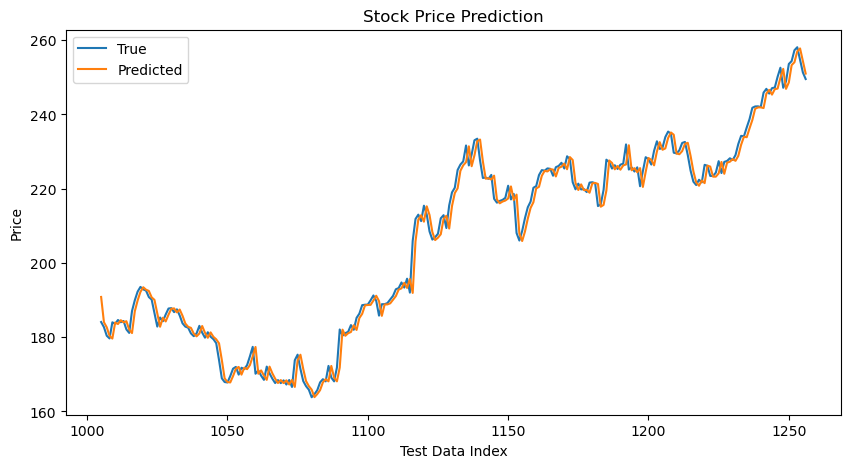

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label='True')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.title('Stock Price Prediction')
plt.xlabel('Test Data Index')
plt.ylabel('Price')
plt.show()


In [2]:
import streamlit as st
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import plotly.graph_objects as go

# App title
st.set_page_config(page_title="Stock Price Predictor", layout="wide")
st.title("📈 Stock Price Predictor")
st.markdown("Enter a stock ticker to predict its next-day closing price using a simple Linear Regression model.")

# Sidebar Inputs
st.sidebar.header("🔧 Settings")
ticker = st.sidebar.text_input("Enter Stock Ticker", "AAPL")
years = st.sidebar.slider("Years of Historical Data", 1, 10, 5)

# Predict Button
if st.sidebar.button("Run Prediction"):
    end_date = pd.to_datetime('today')
    start_date = end_date - pd.DateOffset(years=years)

    with st.spinner("Fetching stock data..."):
        df = yf.download(ticker, start=start_date, end=end_date)

    if df.empty:
        st.error("⚠ No data found for the selected ticker. Please try another one.")
    else:
        # Data preparation
        df = df[['Close']].dropna()
        df['Target'] = df['Close'].shift(-1)
        df = df.dropna()

        X = df[['Close']]
        y = df['Target']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

        # Model training
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Evaluation
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Display metrics
        st.subheader("📊 Model Performance")
        col1, col2 = st.columns(2)
        col1.metric("Mean Squared Error", f"{mse:.2f}")
        col2.metric("R² Score", f"{r2:.2f}")

        # Plot actual vs predicted prices
        chart_df = pd.DataFrame({"Actual Price": y_test, "Predicted Price": y_pred}, index=y_test.index)
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=chart_df.index, y=chart_df["Actual Price"], mode="lines", name="Actual"))
        fig.add_trace(go.Scatter(x=chart_df.index, y=chart_df["Predicted Price"], mode="lines", name="Predicted"))
        fig.update_layout(title=f"{ticker} - Actual vs Predicted Prices",
                          xaxis_title="Date",
                          yaxis_title="Stock Price (USD)",
                          template="plotly_white")
        st.plotly_chart(fig, use_container_width=True)

        # Show latest price info
        latest_price = df['Close'].iloc[-1]
        st.success(f"💰 The latest closing price for **{ticker}** is **${latest_price:.2f}**")
